# **GNN for drug affinity classification**

## Notebook setup and installing necessary libraries

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 15.9 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdMolAlign
from rdkit import RDConfig
from rdkit.Chem.FeatMaps import FeatMaps
from sklearn.model_selection import train_test_split
import networkx as nx
from torch_geometric.utils import from_networkx
import torch

## Downloading the data

In [ ]:
!wget https://raw.githubusercontent.com/dgront/chem-ml/main/INPUTS/data/cyp1a2_veith.tab

--2024-11-26 19:01:47--  https://raw.githubusercontent.com/dgront/chem-ml/main/INPUTS/data/cyp1a2_veith.tab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760372 (743K) [text/plain]
Saving to: ‘cyp1a2_veith.tab’

cyp1a2_veith.tab    100%[===================>] 742.55K  4.08MB/s    in 0.2s    

2024-11-26 19:01:47 (4.08 MB/s) - ‘cyp1a2_veith.tab’ saved [760372/760372]



In [ ]:
!mv cyp1a2_veith.tab data.tab

In [ ]:
!head data.tab

Drug_ID	Drug	Y
6602638.0	"CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl"	0
644510.0	"O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)cc1)OCO3"	1
1960010.0	"CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21"	1
644675.0	"CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1"	1
644851.0	"Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1"	1
644968.0	"COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1"	1
6602688.0	"Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c(Cl)c1"	1
5768708.0	"COc1ccc(/C(O)=C2/C(=O)C(=O)N(CCCC(=O)O)C2c2ccc(OC)cc2)cc1"	0
645323.0	"COc1ccc(Nc2nc(N)nc(CSc3n[nH]c(-c4ccccc4)n3)n2)cc1"	1


## Data analysys

In [ ]:
df = pd.read_csv('data.tab', sep='\t', names=['id', 'smiles', 'label'], header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12579 entries, 0 to 12578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      12579 non-null  float64
 1   smiles  12579 non-null  object 
 2   label   12579 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 294.9+ KB


In [ ]:
print((df.label == 0).sum())
print((df.label == 1).sum())

6750
5829


In [ ]:
df.head(10)

,id,smiles,label
0,6602638.0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0
1,644510.0,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,1
2,1960010.0,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1
3,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1
4,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1
5,644968.0,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1
6,6602688.0,Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c...,1
7,5768708.0,COc1ccc(/C(O)=C2/C(=O)C(=O)N(CCCC(=O)O)C2c2ccc...,0
8,645323.0,COc1ccc(Nc2nc(N)nc(CSc3n[nH]c(-c4ccccc4)n3)n2)cc1,1
9,645573.0,CCN(CC)C(=O)CSc1nnc(-c2cc3ccccc3cc2O)n1CC,1


## SMILES parsing

In [ ]:
def smiles_to_graph(smiles):
    # Step 1: Parse SMILES
    mol = Chem.MolFromSmiles(smiles)

    # Initialize a graph object
    graph = nx.Graph()

    # Step 2: Add atoms as nodes
    for atom in mol.GetAtoms():
        node_id = atom.GetIdx()
        graph.add_node(
            node_id,
            element=atom.GetSymbol(),
            atomic_num=atom.GetAtomicNum(),
            degree=atom.GetDegree(),
            formal_charge=atom.GetFormalCharge(),
            hybridization=str(atom.GetHybridization()),
            is_aromatic=atom.GetIsAromatic()
        )

    # Step 3: Add bonds as edges
    for bond in mol.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        bond_type = str(bond.GetBondType())  # e.g., SINGLE, DOUBLE, TRIPLE, AROMATIC
        graph.add_edge(
            start_atom, end_atom,
            bond_type=bond_type,
            is_conjugated=bond.GetIsConjugated(),
            is_aromatic=bond.GetIsAromatic()
        )

    return graph

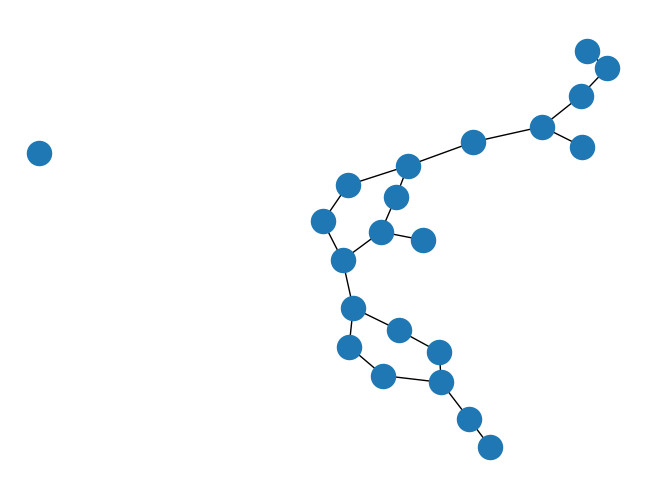

In [ ]:
G = smiles_to_graph('CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl')
nx.draw(G)

In [ ]:
for node, data in G.nodes(data=True):
    print(node)
    print(data)

0
{'element': 'C', 'atomic_num': 6, 'degree': 1, 'formal_charge': 0, 'hybridization': 'SP3', 'is_aromatic': False}
1
{'element': 'C', 'atomic_num': 6, 'degree': 2, 'formal_charge': 0, 'hybridization': 'SP3', 'is_aromatic': False}
2
{'element': 'C', 'atomic_num': 6, 'degree': 2, 'formal_charge': 0, 'hybridization': 'SP3', 'is_aromatic': False}
3
{'element': 'C', 'atomic_num': 6, 'degree': 3, 'formal_charge': 0, 'hybridization': 'SP2', 'is_aromatic': False}
4
{'element': 'O', 'atomic_num': 8, 'degree': 1, 'formal_charge': 0, 'hybridization': 'SP2', 'is_aromatic': False}
5
{'element': 'N', 'atomic_num': 7, 'degree': 2, 'formal_charge': 0, 'hybridization': 'SP2', 'is_aromatic': False}
6
{'element': 'C', 'atomic_num': 6, 'degree': 3, 'formal_charge': 0, 'hybridization': 'SP2', 'is_aromatic': True}
7
{'element': 'C', 'atomic_num': 6, 'degree': 2, 'formal_charge': 0, 'hybridization': 'SP2', 'is_aromatic': True}
8
{'element': 'C', 'atomic_num': 6, 'degree': 2, 'formal_charge': 0, 'hybridizatio

# SMILES featurization

In [ ]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        # Iterate through all feature types
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            # Enumerate all feature values in separate dictionaries for each feature
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            # Set encoding size to summed numbers of all feature values
            self.dim += len(s)

    def encode(self, inputs):
        # One-hot-style encoding of all separate features
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            # Get all separate features
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            # Change encoding to 1 at a specific feature_mapping index
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        # Extra slot for self-loops
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            # Encode self-loop
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [ ]:
bond_featurizer.features_mapping

{'bond_type': {'aromatic': 0, 'double': 1, 'single': 2, 'triple': 3},
 'conjugated': {False: 4, True: 5}}

# Molecules to graphs

In [ ]:
from torch_geometric.data import Data


def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    pair_indices = []
    bond_features = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        # Get all neighboring atoms (nodes) and bonds (edges)
        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(pair_indices).T, np.array(bond_features)


def graphs_from_smiles(smiles_list, label_list):
    # Initialize graphs
    data_list = []

    for smiles, label in zip(smiles_list, label_list):
        molecule = molecule_from_smiles(smiles)
        atom_features, pair_indices, bond_features = graph_from_molecule(molecule)

        # Convert graphs to torch geometric Data
        x = torch.tensor(atom_features, dtype=torch.float32)
        edge_index = torch.tensor(pair_indices, dtype=torch.int64)
        edge_attr = torch.tensor(bond_features, dtype=torch.float32)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=label)

        # Prepare graphs for the loader
        data_list.append(data)

    return data_list

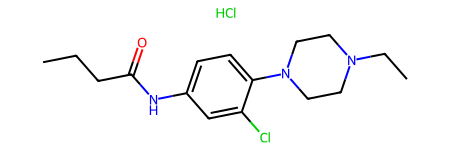

In [ ]:
# Test SMILES parsing
mol0 = molecule_from_smiles(df.smiles[0])
mol0

In [ ]:
# Test graph creation
graph = graph_from_molecule(mol0)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tpair indecies\t", graph[1].shape)
print("\tbond features\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (22, 29)
	pair indecies	 (2, 66)
	bond features	 (66, 7)


In [ ]:
# Test graph data creation
graphs_test = graphs_from_smiles(df['smiles'][0:2], df['label'][0:2])
print(graphs_test[0])
print(graphs_test[0].validate(raise_on_error=True))
print(graphs_test[1])
print(graphs_test[1].validate(raise_on_error=True))
print(graphs_test[0].keys())
print(graphs_test[0].x)
print(graphs_test[0].num_node_features)
print(graphs_test[0].has_isolated_nodes())
print(graphs_test[0].is_undirected())

Data(x=[22, 29], edge_index=[2, 66], edge_attr=[66, 7], y=0)
True
Data(x=[34, 29], edge_index=[2, 110], edge_attr=[110, 7], y=1)
True
['edge_index', 'x', 'edge_attr', 'y']
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1

# Prepare data

In [ ]:
from random import shuffle

data_list = graphs_from_smiles(df['smiles'], df['label'])
shuffle(data_list)
len(data_list)

12579

# Implementing the Graph Convolutional Network

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gdp


class GCN(torch.nn.Module):
    def __init__(self, embedding_size=64):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(29, embedding_size)  # 29 features
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        # self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size, 2)  # Input size for joined gmp and gap, output size 2 for binary classification

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)  # TEST RELU

        # Next conv layers
        hidden = F.dropout(hidden, p=0.2, training=self.training)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = F.dropout(hidden, p=0.2, training=self.training)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        # hidden = self.conv3(hidden, edge_index)
        # hidden = F.relu(hidden)

        # Global pooling layer (stack different aggregations)
        # hidden = torch.cat([gap(hidden, batch_index),
        #                     gmp(hidden, batch_index)], dim=1) # Try global add pull
        hidden = gdp(hidden, batch_index)

        # Apply a final (linear) classifier
        hidden = F.dropout(hidden, p=0.2, training=self.training)
        out = self.out(hidden)

        # Return sigmoid activation for binary classification
        return F.softmax(out, dim=1), hidden

model = GCN()
print(model)
print('Number of parameters: ', sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(29, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (out): Linear(in_features=64, out_features=2, bias=True)
)
Number of parameters:  10370


# Train GCN model

In [ ]:
from torch_geometric.loader import DataLoader

model = GCN()

# Crossentropy loss
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Device type:', device)

# Wrap data in a data loader
data_size = len(data_list)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(data_list[:int(0.8*data_size)],
                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data_list[int(0.8*data_size):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(loader):
    model.train()
    # Iterate over the data
    total_loss = 0.0
    for batch in loader:
        # Use GPU
        optimizer.zero_grad()
        batch.to(device)
        # Passing the node features and the connection info
        out, embedding = model(batch.x, batch.edge_index, batch.batch)
        # Calculating the loss and gradients
        loss = criterion(out, batch.y)
        total_loss += loss.item()
        loss.backward()
        # Update using the gradients
        optimizer.step()
        # Reset gradient

    return total_loss, embedding

def test(loader):
    model.eval()

    correct = 0
    for batch in loader:  # Iterate in batches over the training/test dataset.
         batch.to(device)
         out, h = model(batch.x, batch.edge_index, batch.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == batch.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

print('Starting training...')
losses = []
train_accuracy_list = []
test_accuracy_list = []
epochs = 50
for epoch in range(epochs):
    loss, h = train(train_loader)
    losses.append(loss)
    train_acc = test(train_loader)
    train_accuracy_list.append(train_acc)
    test_acc = test(test_loader)
    test_accuracy_list.append(test_acc)
    print(f'Epoch: {epoch+1} | Train loss: {loss:.4} | Train accuracy: {train_acc:.4} | Test accuracy: {test_acc:.4}')

Device type: cuda:0
Starting training...
Epoch: 1 | Train loss: 95.26 | Train accuracy: 0.7319 | Test accuracy: 0.7361
Epoch: 2 | Train loss: 88.13 | Train accuracy: 0.7633 | Test accuracy: 0.7635
Epoch: 3 | Train loss: 86.28 | Train accuracy: 0.7714 | Test accuracy: 0.7647
Epoch: 4 | Train loss: 84.66 | Train accuracy: 0.7763 | Test accuracy: 0.7731
Epoch: 5 | Train loss: 84.02 | Train accuracy: 0.7766 | Test accuracy: 0.7659
Epoch: 6 | Train loss: 83.81 | Train accuracy: 0.7816 | Test accuracy: 0.7715
Epoch: 7 | Train loss: 83.25 | Train accuracy: 0.7774 | Test accuracy: 0.7901
Epoch: 8 | Train loss: 82.97 | Train accuracy: 0.7897 | Test accuracy: 0.7874
Epoch: 9 | Train loss: 82.23 | Train accuracy: 0.7904 | Test accuracy: 0.7866
Epoch: 10 | Train loss: 82.38 | Train accuracy: 0.745 | Test accuracy: 0.7345
Epoch: 11 | Train loss: 82.5 | Train accuracy: 0.7985 | Test accuracy: 0.7937
Epoch: 12 | Train loss: 81.79 | Train accuracy: 0.7989 | Test accuracy: 0.7905
Epoch: 13 | Train loss

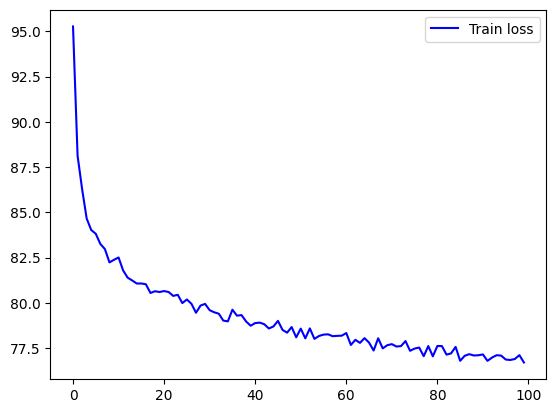

In [ ]:
#losses = [loss.cpu().detach().numpy() for loss in losses]
plt.plot(losses, 'b', label='Train loss')
plt.legend()
plt.show()

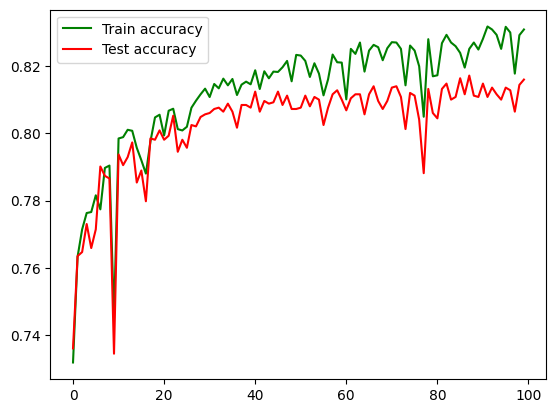

In [ ]:
plt.plot(train_accuracy_list, 'g', label='Train accuracy')
plt.plot(test_accuracy_list, 'r', label='Test accuracy')
plt.legend()
plt.show()

#Implement NNConv network

In [ ]:
from torch.nn import Linear, Sequential, ReLU
import torch.nn.functional as F
from torch_geometric.nn import NNConv, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gdp


class Edge_NN(torch.nn.Module):
    def __init__(self, embedding_size=64):
        # Init parent
        super(Edge_NN, self).__init__()
        torch.manual_seed(42)

        # Mapping layer for NNConv
        mlp = Sequential(Linear(7, 7), ReLU(), Linear(7, 29 * embedding_size)) # maps to in_channels * out_channels

        # NNLayer
        self.conv1 = NNConv(29, embedding_size, mlp)
        # self.conv1_bn = BatchNorm(embedding_size)

        # Next message passing layers
        self.conv2 = GCNConv(embedding_size, embedding_size)
        # self.conv2_bn = BatchNorm(embedding_size)

        # Output layer
        self.out = Linear(embedding_size, 2)  # Input size for joined gmp and gap, output size 2 for binary classification

    def forward(self, x, edge_index, edge_attr, batch_index):

        hidden = self.conv1(x, edge_index, edge_attr)
        # hidden = self.conv1_bn(hidden)
        hidden = F.relu(hidden)

        hidden = F.dropout(hidden, p=0.3, training=self.training)

        hidden = self.conv2(hidden, edge_index)
        # hidden = self.conv2_bn(hidden)
        hidden = F.relu(hidden)

        # Apply global add pulling
        hidden = gdp(hidden, batch_index)  # Try other pulling layers

        # Apply a final (linear) classifier
        hidden = F.dropout(hidden, p=0.3, training=self.training)
        out = self.out(hidden)

        # Return sigmoid activation for binary classification
        return F.softmax(out, dim=1), hidden

model = Edge_NN()
print(model)
print('Number of parameters: ', sum(p.numel() for p in model.parameters()))

Edge_NN(
  (conv1): NNConv(29, 64, aggr=add, nn=Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=1856, bias=True)
  ))
  (conv2): GCNConv(64, 64)
  (out): Linear(in_features=64, out_features=2, bias=True)
)
Number of parameters:  21114


#Train the NNConv network

In [ ]:
from torch_geometric.loader import DataLoader

model = Edge_NN()

# Crossentropy loss
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Device type:', device)

# Wrap data in a data loader
data_size = len(data_list)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(data_list[:int(0.8*data_size)],
                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data_list[int(0.8*data_size):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(loader):
    model.train()
    # Iterate over the data
    total_loss = 0.0
    for batch in loader:
        # Reset gradient
        optimizer.zero_grad()
        # Use GPU
        batch.to(device)
        # Passing the node features and the connection info
        out, embedding = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        # Calculating the loss and gradients
        loss = criterion(out, batch.y)
        total_loss += loss.item()
        loss.backward()
        # Update using the gradients
        optimizer.step()


    return total_loss, embedding

def test(loader):
    model.eval()

    correct = 0
    for batch in loader:  # Iterate in batches over the training/test dataset.
         batch.to(device)
         out, h = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == batch.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

print('Starting training...')
losses = []
train_accuracy_list = []
test_accuracy_list = []
epochs = 100
for epoch in range(epochs):
    loss, h = train(train_loader)
    losses.append(loss)
    train_acc = test(train_loader)
    train_accuracy_list.append(train_acc)
    test_acc = test(test_loader)
    test_accuracy_list.append(test_acc)
    print(f'Epoch: {epoch+1} | Train loss: {loss:.4} | Train accuracy: {train_acc:.4} | Test accuracy: {test_acc:.4}')

Device type: cuda:0
Starting training...
Epoch: 1 | Train loss: 105.3 | Train accuracy: 0.7141 | Test accuracy: 0.7234
Epoch: 2 | Train loss: 94.11 | Train accuracy: 0.7323 | Test accuracy: 0.7369
Epoch: 3 | Train loss: 91.03 | Train accuracy: 0.7558 | Test accuracy: 0.7568
Epoch: 4 | Train loss: 89.25 | Train accuracy: 0.7568 | Test accuracy: 0.7603
Epoch: 5 | Train loss: 87.52 | Train accuracy: 0.7749 | Test accuracy: 0.7711
Epoch: 6 | Train loss: 85.84 | Train accuracy: 0.7794 | Test accuracy: 0.7842
Epoch: 7 | Train loss: 84.71 | Train accuracy: 0.786 | Test accuracy: 0.7798
Epoch: 8 | Train loss: 84.06 | Train accuracy: 0.7831 | Test accuracy: 0.7846
Epoch: 9 | Train loss: 82.92 | Train accuracy: 0.7885 | Test accuracy: 0.7882
Epoch: 10 | Train loss: 82.52 | Train accuracy: 0.7991 | Test accuracy: 0.7874
Epoch: 11 | Train loss: 81.72 | Train accuracy: 0.7965 | Test accuracy: 0.7882
Epoch: 12 | Train loss: 81.2 | Train accuracy: 0.8023 | Test accuracy: 0.7953
Epoch: 13 | Train loss

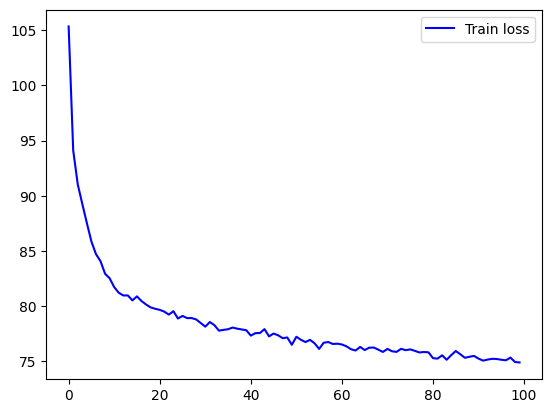

In [ ]:
#losses = [loss.cpu().detach().numpy() for loss in losses]
plt.plot(losses, 'b', label='Train loss')
plt.legend()
plt.show()

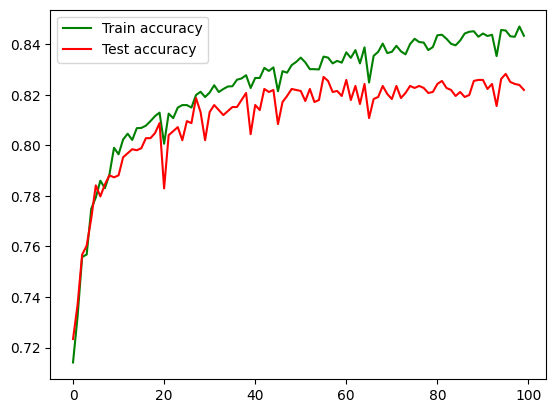

In [ ]:
plt.plot(train_accuracy_list, 'g', label='Train accuracy')
plt.plot(test_accuracy_list, 'r', label='Test accuracy')
plt.legend()
plt.show()

# Hyperparameter optimization

In [ ]:
model = Edge_NN()

# Optimizer param grid
param_grid = {
    'lr': [0.0001, 0.0005, 0.001, 0.01],
    'eps': [1e-8, 1e-7, 1e-6],
    'betas': [(0.9, 0.99), (0.9, 0.98), (0.8, 0.99), (0.8, 0.98)]
}

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
# Crossentropy loss
criterion = torch.nn.CrossEntropyLoss()

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Device type:', device)


print('Starting training...')
for param in grid:

    epochs = 100
    for epoch in range(epochs):
        loss, h = train(train_loader)
        losses.append(loss)
        train_acc = test(train_loader)
        train_accuracy_list.append(train_acc)
        test_acc = test(test_loader)
        test_accuracy_list.append(test_acc)
        if epoch % 25 == 0:
            print(f'Epoch: {epoch+1} | Train loss: {loss:.4} | Train accuracy: {train_acc:.4} | Test accuracy: {test_acc:.4}')